In [103]:
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np
from time import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, roc_auc_score

pd.set_option("display.max_columns", None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [104]:
# Load data
df = pd.read_csv('census.csv')
df.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


# I. Explore data

## Check duplicates

In [105]:
df.duplicated().sum()

5982

- There are 5982 duplicated rows, let's remove them

In [106]:
df.drop_duplicates(inplace=True)
df.duplicated().sum() # test

0

## Check dtypes

In [107]:
df.dtypes

age                  int64
workclass           object
education_level     object
education-num      float64
marital-status      object
occupation          object
relationship        object
race                object
sex                 object
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country      object
income              object
dtype: object

## Basic stats

- Numeric cols:

In [108]:
def missing_ratio(s):
    return s.isna().sum() * 100 / len(s)

num_cols = df.select_dtypes([np.int64, np.float64]).columns.tolist()
df[num_cols].agg([missing_ratio, pd.Series.min, pd.Series.max, pd.Series.nunique])

,age,education-num,capital-gain,capital-loss,hours-per-week
missing_ratio,0.0,0.0,0.0,0.0,0.0
min,17.0,1.0,0.0,0.0,1.0
max,90.0,16.0,99999.0,4356.0,99.0
nunique,74.0,16.0,121.0,97.0,96.0


- Categorical cols:

In [109]:
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
df[cat_cols].agg([missing_ratio, pd.Series.nunique, pd.Series.unique])

,workclass,education_level,marital-status,occupation,relationship,race,sex,native-country,income
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nunique,7,16,7,14,6,5,2,41,2
unique,"[ State-gov, Self-emp-not-inc, Private, Fed...","[ Bachelors, HS-grad, 11th, Masters, 9th, ...","[ Never-married, Married-civ-spouse, Divorce...","[ Adm-clerical, Exec-managerial, Handlers-cl...","[ Not-in-family, Husband, Wife, Own-child, ...","[ White, Black, Asian-Pac-Islander, Amer-In...","[ Male, Female]","[ United-States, Cuba, Jamaica, India, Mex...","[<=50K, >50K]"


## Check distribution & relation

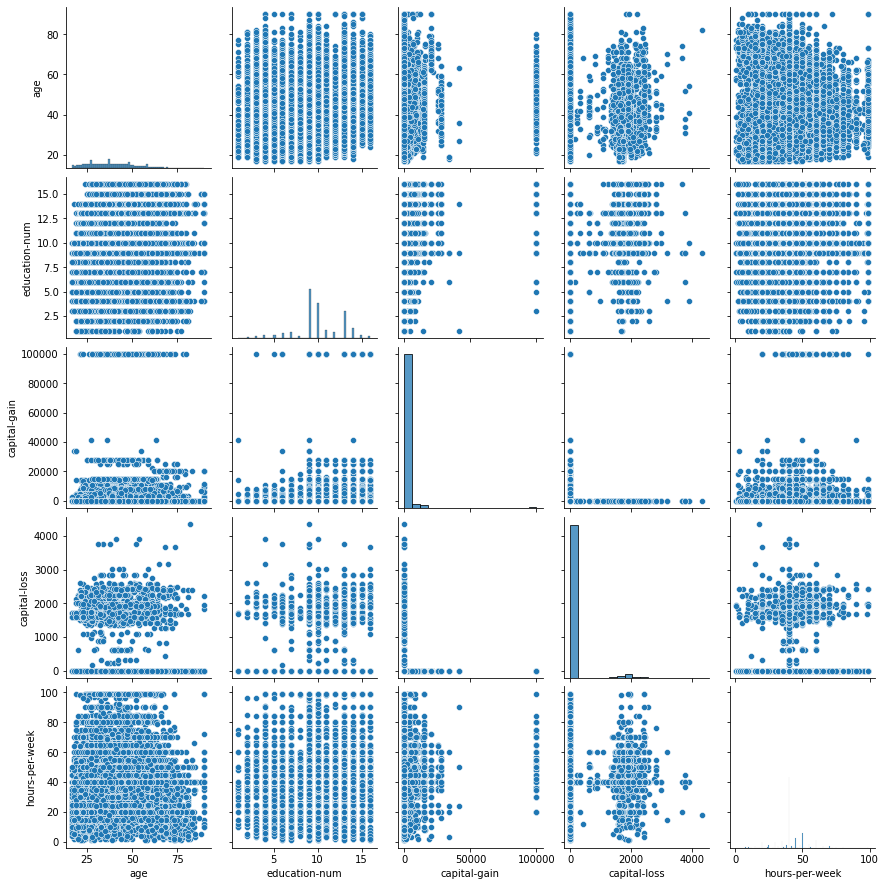

In [110]:
sns.pairplot(df)

- Zoom in `age` & `hours-per-week`

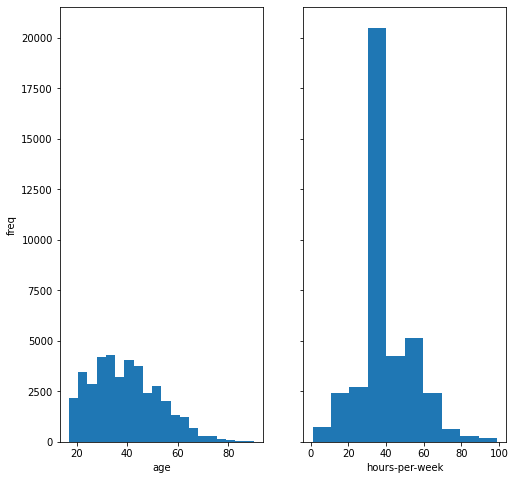

In [111]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,8))
ax[0].hist(df['age'], bins=20)
ax[0].set_xlabel('age')
ax[0].set_ylabel('freq')
ax[1].hist(df['hours-per-week'])
ax[1].set_xlabel('hours-per-week');

$\to$ Frequency of (`hours-per-week` = 40) seems suspicious (too high). Let's plot boxplot to see whether there are any outliers

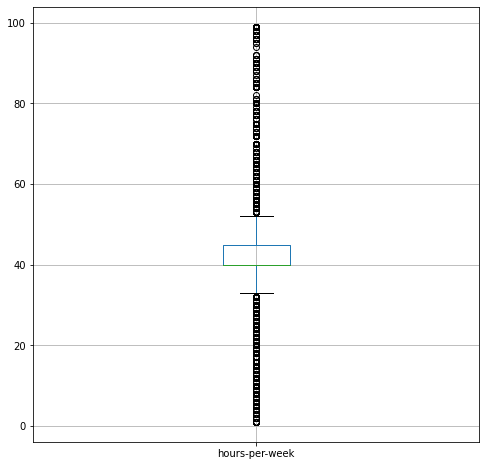

In [112]:
df.boxplot('hours-per-week', figsize=(8,8));

$\to$ To many outliers!

# Conclusion
In the next stage, consider:
- Normalize all numeric data
- Encode all categorical data
- The target col (`income`) should be mapped into 1 & 0
- `age`, `capital-loss`, `capital-gain` are skewed to the right
- `hours-per-week` has outliers

## II. Preprocessing

- Let's not know too deep about the validation data by splitting `df` into train & validation set

In [113]:
y_sr = df["income"] 
X_df = df.drop("income", axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_df, y_sr, test_size=0.2, random_state=0)
X_train.shape, X_val.shape

((31392, 13), (7848, 13))

## 1. `hours-per-week` has outliers

- Because `hours-per-week`'s distribution is close to normal distribution, so just take 3 standard deviation from the mean

In [114]:
mean, std = df['hours-per-week'].mean(), df['hours-per-week'].std()
df = df[df['hours-per-week'] <= (mean + 3*std)]
df = df[df['hours-per-week'] >= (mean - 3*std)]

## 2. Create a preprocessing pipeline

The order we should preprocess: 
- Encode categorical data, so that categorical data is converted to numeric
- For original numeric cols, use log(n+1) (`np.log1p`) to remove skewness
- Finally, when the input is all numeric, apply `MaxAbsScaler` method to scale the data

In [115]:
skewed_cols = ['age', 'capital-loss', 'capital-gain']
cat_cols.remove('income')

preprocess_pipeline = Pipeline([
    ('column_transform', ColumnTransformer([('cat_transform', OneHotEncoder(), cat_cols),
                                            ('skewed_data_transformer', FunctionTransformer(np.log1p), skewed_cols)], 
                                           remainder='passthrough')),
    ('scaler', MaxAbsScaler())
])

In [116]:
preprocess_pipeline.fit_transform(X_train) # test

<31392x103 sparse matrix of type '<class 'numpy.float64'>'
	with 350043 stored elements in Compressed Sparse Row format>

## 3. The target col (`income`) should be mapped into 1 & 0

- Because this problem is related to target col, so we cannot add this step to the pipeline above. But we can create a function that can preprocess both **feature cols** & **target col**. Let's name the function `preprocess`

In [134]:
def preprocess(X_df, y_sr, preprocess_pipeline, fit_transform=False):
    '''Preprocess X_df & y_sr
        For X_df (train/validation):
            - Encode categorical cols
            - Remove skewness of ['age', 'capital-loss', 'capital-gain']
            - Scaling
        For y_sr: Map to 0 & 1
    '''
    # preprocess X_df
    if fit_transform: # train_set
        preprocessed_X = preprocess_pipeline.fit_transform(X_df)
    else: # validation_set
        preprocessed_X = preprocess_pipeline.transform(X_df)
    
    # preprocess y_sr
    preprocessed_y = y_sr.map({'>50K': 1, '<=50K': 0})
    
    return preprocessed_X, preprocessed_y

# III. ML models

- Prepare the input

In [136]:
preprocessed_X_train, preprocessed_y_train = preprocess(X_train, y_train, preprocess_pipeline, fit_transform=True)
preprocessed_X_val, preprocessed_y_val = preprocess(X_val, y_val, preprocess_pipeline)

- Generalize the training & predicting phase of all models

In [137]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
   '''
   inputs:
      - learner: the learning algorithm to be trained and predicted on
      - sample_size < 1: the size of samples (number) to be drawn from training set
      - X_train: features training set
      - y_train: income training set
      - X_test: features testing set
      - y_test: income testing set
   output: a dictionary with each key:
      - train_time, pred_time
      - acc_train, auc_train: accuracy & auc of the prediction of the first 300 training samples
      - acc_test, auc_test
   '''
   results = {}
   
   # Fitting (training) phase
   start = time() 
   learner = learner.fit(X_train[:int(X_train.shape[0]*sample_size)], y_train[:int(X_train.shape[0]*sample_size)])
   end = time() 
   results['train_time'] = end - start 
   # breakpoint()
   
   # prediction phase
   start = time() 
   predictions_test = learner.predict(X_test)
   predictions_train = learner.predict(X_train[:300])
   end = time()
   results['pred_time'] = end - start
   # breakpoint()
         
   # accuracy
   results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
   results['acc_test'] = accuracy_score(y_test, predictions_test)
   
   # AUC (always < 1)
   results['auc_train'] = roc_auc_score(y_train[:300], predictions_train)
   results['auc_test'] = roc_auc_score(y_test, predictions_test)
      
   # verbose
   print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
      
   return results

- Init 3 models

In [128]:
clf_A = RandomForestClassifier(random_state=42)
clf_B = GradientBoostingClassifier(random_state=42)
clf_C = xgb.XGBClassifier(random_state=42)

In [138]:
samples_100 = len(y_train)
samples_10 = 0.1*len(y_train)
samples_1 = 0.01*len(y_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, preprocessed_X_train, preprocessed_y_train, 
                                                           preprocessed_X_val, preprocessed_y_val)

RandomForestClassifier trained on 313.92 samples.
RandomForestClassifier trained on 3139.2000000000003 samples.
RandomForestClassifier trained on 31392 samples.
GradientBoostingClassifier trained on 313.92 samples.
GradientBoostingClassifier trained on 3139.2000000000003 samples.
GradientBoostingClassifier trained on 31392 samples.
[22:37:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier trained on 313.92 samples.
[22:37:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier trained on 3139.2000000000003 samples.
[22:37:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier trained on 31392 samples.


- Plotting 3 models based on certain criteria: time, acccuracy, AUC

In [147]:
def evaluate(results):
    import matplotlib.patches as mpatches
    # Create figure
    fig, ax = plt.subplots(2, 3, figsize = (11,7))
    # Constants
    bar_width = 0.3
    colors = ['navy','yellow','green']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'auc_train', 'pred_time', 'acc_test', 'auc_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("AUC")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("AUC")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("AUC on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Validation Set")
    ax[1, 2].set_title("AUC on Validation Set")

    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))
    plt.tight_layout()
    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.07)
    plt.show()


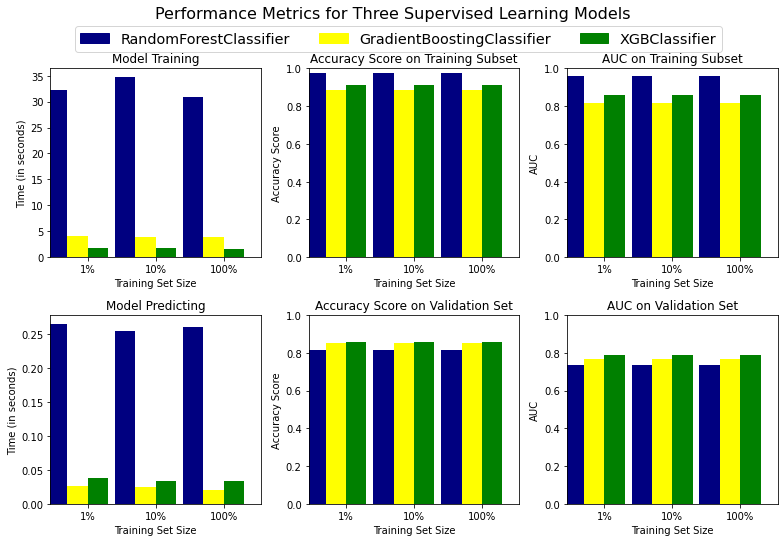

In [148]:
evaluate(results)

Some comments about the above chart: 
- Time: Random Forest is the worst as its training & predicting time for any subsets of training set (1%, 10%, 100%) are the highest bars
- Accuracy: Random Forest achieves the highest accuracy only on training set and works less efficient on validation set compared to the other 2 models. In other words, Random forest is overfitted while the other 2 models are well-fitted on the validation set (and it's hard to see which one is better at predicting validation data from the second-vertical images). 
- AUC: This one shows clearly that Random forest is overfitted. Besides, `XGBClassifier` is the best predictor as it has the highest AUC on validation set

In [150]:
best_model = results['XGBClassifier']
best_model

{0: {'train_time': 1.6794729232788086,
  'pred_time': 0.03790020942687988,
  'acc_train': 0.91,
  'acc_test': 0.8588175331294597,
  'auc_train': 0.8568322981366461,
  'auc_test': 0.7870370474637631},
 1: {'train_time': 1.6944668292999268,
  'pred_time': 0.03390669822692871,
  'acc_train': 0.91,
  'acc_test': 0.8588175331294597,
  'auc_train': 0.8568322981366461,
  'auc_test': 0.7870370474637631},
 2: {'train_time': 1.6436009407043457,
  'pred_time': 0.03390908241271973,
  'acc_train': 0.91,
  'acc_test': 0.8588175331294597,
  'auc_train': 0.8568322981366461,
  'auc_test': 0.7870370474637631}}